# 01 - Exploratory Data Analysis (EDA)

This notebook performs comprehensive EDA on the business events data:
- Load Delta/Parquet tables
- Distribution plots for numeric features
- Correlation matrices
- Missingness heatmap
- KPI summaries

## 1. Setup & Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from datetime import datetime

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Libraries loaded successfully!")

Libraries loaded successfully!


## 2. Data Loading

Load from Delta tables when available, with Parquet fallback for development.

In [2]:
def load_events_data(delta_path: str = None, parquet_path: str = None) -> pd.DataFrame:
    """
    Load events data from Delta Lake or Parquet.
    Falls back to Parquet if Delta is unavailable.
    """
    # Try Delta first
    if delta_path:
        try:
            from deltalake import DeltaTable
            dt = DeltaTable(delta_path)
            df = dt.to_pandas()
            print(f"Loaded {len(df):,} rows from Delta table: {delta_path}")
            return df
        except Exception as e:
            print(f"Delta loading failed: {e}")
    
    # Fallback to Parquet
    if parquet_path:
        df = pd.read_parquet(parquet_path)
        print(f"Loaded {len(df):,} rows from Parquet: {parquet_path}")
        return df
    
    raise FileNotFoundError("No valid data source provided")


# Configure paths
PROJECT_ROOT = Path(".").resolve().parent
DELTA_PATH = PROJECT_ROOT / "data" / "lake" / "delta" / "events"  # Future Delta location
PARQUET_PATH = PROJECT_ROOT / "data" / "sample" / "events.parquet"

# Load data
df = load_events_data(
    delta_path=str(DELTA_PATH) if DELTA_PATH.exists() else None,
    parquet_path=str(PARQUET_PATH)
)

print(f"\nDataset shape: {df.shape}")

Loaded 50,000 rows from Parquet: /home/onlyahad/Desktop/Flagship Project/data/sample/events.parquet

Dataset shape: (50000, 8)


In [3]:
# Parse metadata JSON if stored as string
if 'metadata' in df.columns and df['metadata'].dtype == 'object':
    df['metadata'] = df['metadata'].apply(
        lambda x: json.loads(x) if isinstance(x, str) else x
    )

# Extract metadata fields
df['channel'] = df['metadata'].apply(lambda x: x.get('channel') if isinstance(x, dict) else None)
df['device_type'] = df['metadata'].apply(lambda x: x.get('device_type') if isinstance(x, dict) else None)

# Parse timestamp
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.day_name()

# Calculate revenue
df['revenue'] = df['price'] * df['quantity']

print("Feature engineering complete!")
df.head()

Feature engineering complete!


,id,timestamp,user_id,product_id,price,quantity,location,metadata,channel,device_type,date,hour,day_of_week,revenue
0,3c7b64d7-037b-4754-abdb-97e422a95ebd,2024-11-01 00:01:00+00:00,usr_68b4f725-f75,prod_0d6cc1f9,32.76,2,"Brittanyshire, Lesotho","{'channel': 'api', 'device_type': 'tablet', 's...",api,tablet,2024-11-01,0,Friday,65.52
1,627fa9af-5551-4790-ace6-5a128e383f4d,2024-11-01 00:03:41+00:00,usr_c7897a52-402,prod_40382f0f,242.18,7,"Chavezburgh, Poland","{'channel': 'web', 'device_type': 'smart_tv', ...",web,smart_tv,2024-11-01,0,Friday,1695.26
2,07b438a8-99ad-46f5-a4d3-37ba83b6481a,2024-11-01 00:03:45+00:00,usr_b1b1b53b-bd7,prod_10d07ade,686.90,3,"South Alyssaville, Pakistan","{'channel': 'api', 'device_type': 'desktop', '...",api,desktop,2024-11-01,0,Friday,2060.70
3,bcae1406-e25b-4be0-9ff9-f1c8cc8f7c07,2024-11-01 00:04:09+00:00,usr_75fba310-929,prod_192865e5,124.84,6,"Mcgeefort, Wallis and Futuna","{'channel': 'mobile', 'device_type': 'smart_tv...",mobile,smart_tv,2024-11-01,0,Friday,749.04
4,283fcefd-cba2-4e2b-b462-d2d55c3e34b7,2024-11-01 00:04:53+00:00,usr_caa79c28-651,prod_f1c8fd2c,856.41,2,"Port Janetstad, Brazil","{'channel': 'api', 'device_type': 'tablet', 's...",api,tablet,2024-11-01,0,Friday,1712.82


## 3. Data Overview

In [4]:
print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)
print(f"\nShape: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"\nDate range: {df['timestamp'].min()} to {df['timestamp'].max()}")
print(f"Time span: {(df['timestamp'].max() - df['timestamp'].min()).days} days")
print("\nColumn types:")
print(df.dtypes)

DATASET OVERVIEW

Shape: 50,000 rows x 14 columns

Date range: 2024-11-01 00:01:00+00:00 to 2024-11-30 23:59:42+00:00
Time span: 29 days

Column types:
id                          object
timestamp      datetime64[ns, UTC]
user_id                     object
product_id                  object
price                      float64
quantity                     int32
location                    object
metadata                    object
channel                     object
device_type                 object
date                        object
hour                         int32
day_of_week                 object
revenue                    float64
dtype: object


In [5]:
df.describe()

,price,quantity,hour,revenue
count,50000.00,50000.00,50000.00,50000.00
mean,498.19,5.51,11.52,2742.74
std,288.72,2.87,6.93,2292.44
min,1.02,1.00,0.00,1.02
25%,247.36,3.00,5.00,845.89
50%,500.14,6.00,12.00,2091.10
75%,746.83,8.00,18.00,4128.51
max,999.99,10.00,23.00,9998.30


## 4. Distribution Plots

Visualize the distribution of key numeric features to understand data characteristics.

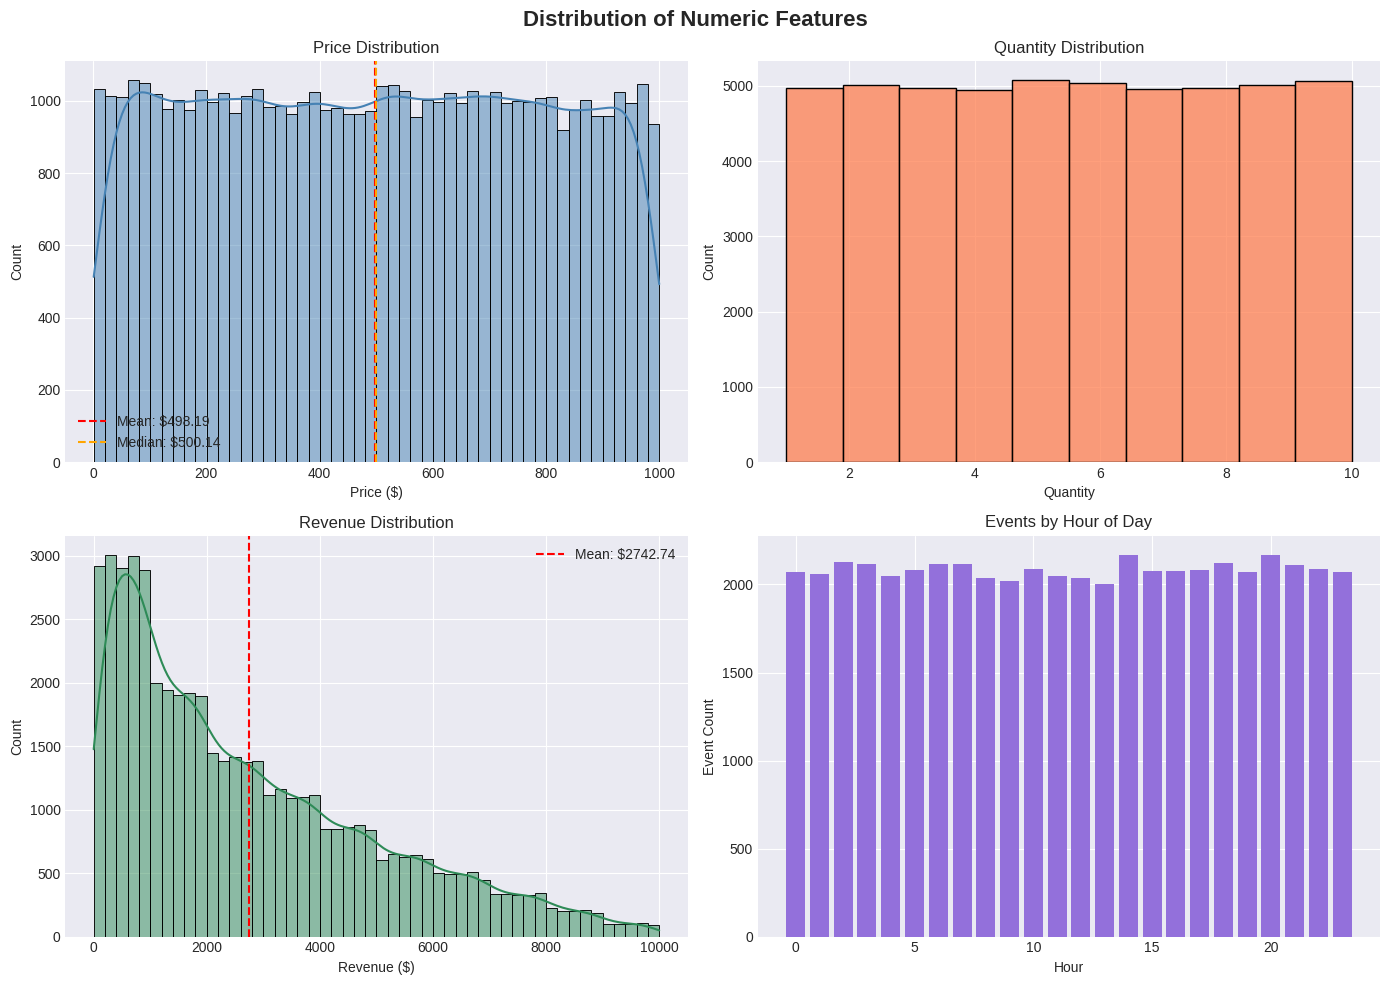

In [6]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of Numeric Features', fontsize=16, fontweight='bold')

# Price distribution
ax1 = axes[0, 0]
sns.histplot(df['price'], bins=50, kde=True, ax=ax1, color='steelblue')
ax1.set_title('Price Distribution')
ax1.set_xlabel('Price ($)')
ax1.axvline(df['price'].mean(), color='red', linestyle='--', label=f'Mean: ${df["price"].mean():.2f}')
ax1.axvline(df['price'].median(), color='orange', linestyle='--', label=f'Median: ${df["price"].median():.2f}')
ax1.legend()

# Quantity distribution
ax2 = axes[0, 1]
sns.histplot(df['quantity'], bins=10, kde=False, ax=ax2, color='coral')
ax2.set_title('Quantity Distribution')
ax2.set_xlabel('Quantity')

# Revenue distribution (log scale)
ax3 = axes[1, 0]
sns.histplot(df['revenue'], bins=50, kde=True, ax=ax3, color='seagreen')
ax3.set_title('Revenue Distribution')
ax3.set_xlabel('Revenue ($)')
ax3.axvline(df['revenue'].mean(), color='red', linestyle='--', label=f'Mean: ${df["revenue"].mean():.2f}')
ax3.legend()

# Hourly distribution
ax4 = axes[1, 1]
hourly_counts = df['hour'].value_counts().sort_index()
ax4.bar(hourly_counts.index, hourly_counts.values, color='mediumpurple')
ax4.set_title('Events by Hour of Day')
ax4.set_xlabel('Hour')
ax4.set_ylabel('Event Count')

plt.tight_layout()
plt.savefig('eda_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

**Interpretation:**
- **Price**: Shows the price range distribution. A right-skewed distribution indicates more low-priced transactions.
- **Quantity**: Integer distribution from 1-10, showing purchase behavior patterns.
- **Revenue**: Combination of price × quantity, revealing the business value distribution.
- **Hourly Pattern**: Identifies peak transaction hours for operational insights.

## 5. Correlation Matrix

Analyze relationships between numeric features.

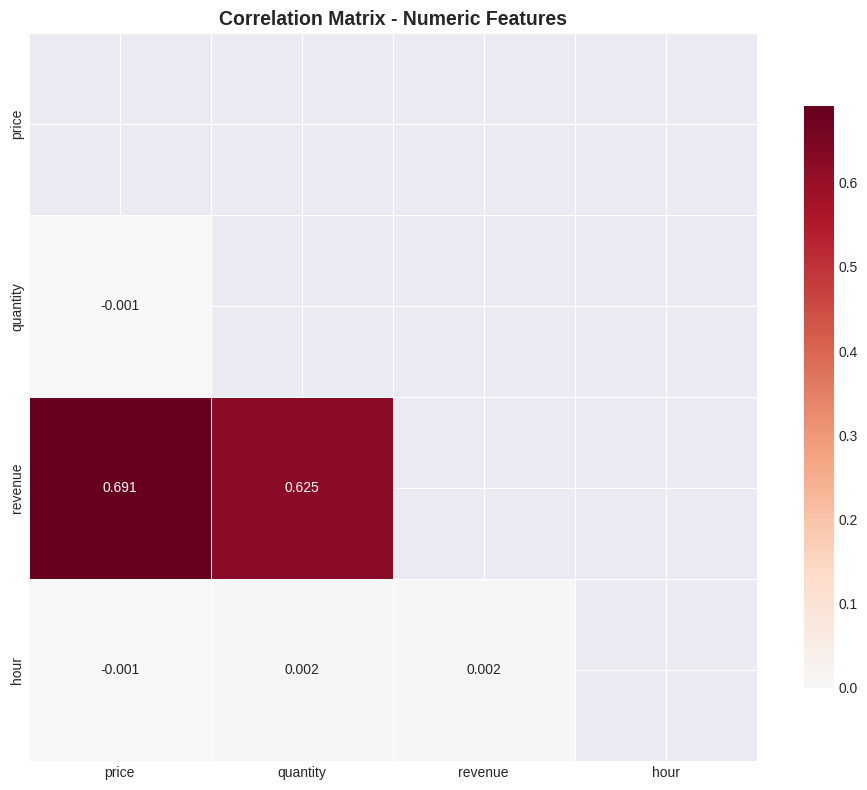


Correlation values:
          price  quantity  revenue  hour
price      1.00     -0.00     0.69 -0.00
quantity  -0.00      1.00     0.63  0.00
revenue    0.69      0.63     1.00  0.00
hour      -0.00      0.00     0.00  1.00


In [7]:
# Select numeric columns for correlation
numeric_cols = ['price', 'quantity', 'revenue', 'hour']
corr_matrix = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt='.3f',
    cmap='RdBu_r',
    center=0,
    square=True,
    linewidths=0.5,
    ax=ax,
    cbar_kws={'shrink': 0.8}
)

ax.set_title('Correlation Matrix - Numeric Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('eda_correlation_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nCorrelation values:")
print(corr_matrix)

**Interpretation:**
- Revenue is strongly correlated with both price and quantity (expected, as revenue = price × quantity)
- Price and quantity may show weak or no correlation, indicating independent purchasing decisions
- Hour shows minimal correlation with transaction values, suggesting consistent behavior across the day

## 6. Missingness Heatmap

Identify patterns in missing data across the dataset.

Missing Value Summary:
id                     0.00%
timestamp              0.00%
user_id                0.00%
product_id             0.00%
price                  0.00%
quantity               0.00%
location               0.00%
metadata               0.00%
channel                0.00%
device_type            0.00%
date                   0.00%
hour                   0.00%
day_of_week            0.00%
revenue                0.00%


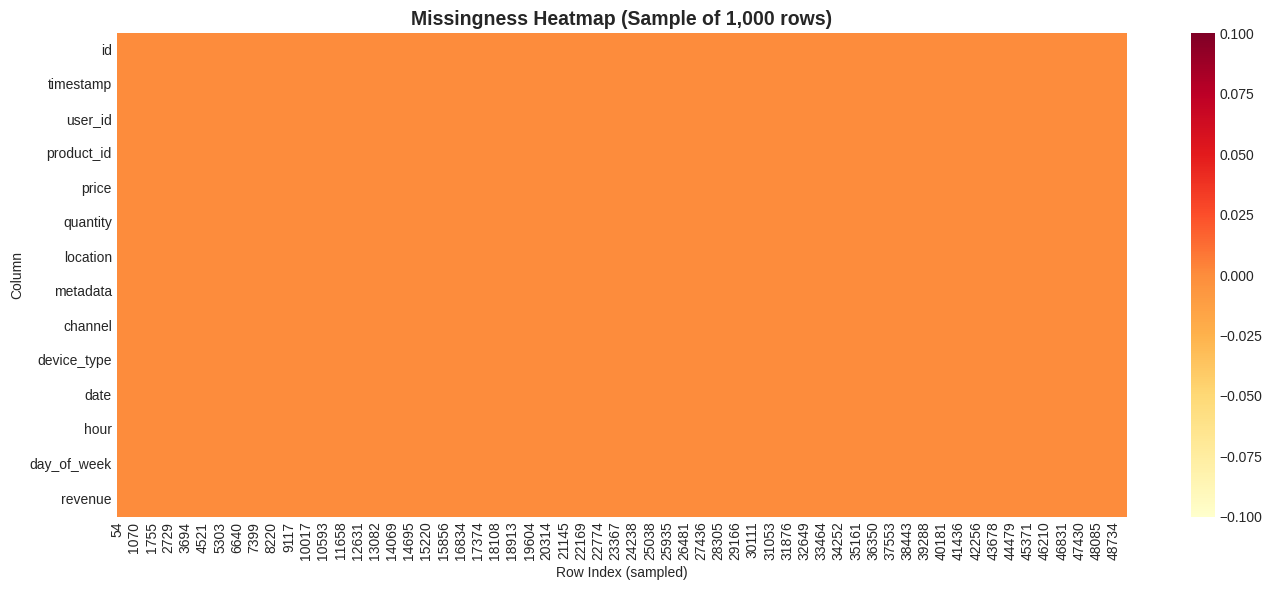

In [8]:
# Calculate missingness
missing_df = df.isnull()
missing_pct = (missing_df.sum() / len(df) * 100).sort_values(ascending=False)

print("Missing Value Summary:")
print("=" * 40)
for col, pct in missing_pct.items():
    print(f"{col:<20} {pct:>6.2f}%")

# Missingness heatmap (sample for large datasets)
sample_size = min(1000, len(df))
sample_idx = np.random.choice(len(df), sample_size, replace=False)
sample_idx = np.sort(sample_idx)

fig, ax = plt.subplots(figsize=(14, 6))
sns.heatmap(
    df.iloc[sample_idx].isnull().T,
    cbar=True,
    cmap='YlOrRd',
    ax=ax,
    yticklabels=True
)
ax.set_title(f'Missingness Heatmap (Sample of {sample_size:,} rows)', fontsize=14, fontweight='bold')
ax.set_xlabel('Row Index (sampled)')
ax.set_ylabel('Column')

plt.tight_layout()
plt.savefig('eda_missingness_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

**Interpretation:**
- Yellow/red cells indicate missing values
- Vertical patterns suggest systematic missing data in specific columns
- Block patterns may indicate batch ingestion issues
- Fully dark rows = complete records

## 7. KPI Summaries

Calculate key business metrics and performance indicators.

In [9]:
# Calculate KPIs
kpis = {
    'Total Transactions': f"{len(df):,}",
    'Total Revenue': f"${df['revenue'].sum():,.2f}",
    'Average Order Value': f"${df['revenue'].mean():.2f}",
    'Median Order Value': f"${df['revenue'].median():.2f}",
    'Unique Users': f"{df['user_id'].nunique():,}",
    'Unique Products': f"{df['product_id'].nunique():,}",
    'Unique Locations': f"{df['location'].nunique():,}",
    'Avg Items per Transaction': f"{df['quantity'].mean():.2f}",
    'Max Single Transaction': f"${df['revenue'].max():,.2f}",
    'Date Range': f"{df['date'].min()} to {df['date'].max()}",
}

print("=" * 60)
print("KEY PERFORMANCE INDICATORS (KPIs)")
print("=" * 60)
for kpi, value in kpis.items():
    print(f"{kpi:<30} {value}")

KEY PERFORMANCE INDICATORS (KPIs)
Total Transactions             50,000
Total Revenue                  $137,136,929.35
Average Order Value            $2742.74
Median Order Value             $2091.10
Unique Users                   50,000
Unique Products                50,000
Unique Locations               49,607
Avg Items per Transaction      5.51
Max Single Transaction         $9,998.30
Date Range                     2024-11-01 to 2024-11-30


In [10]:
# Channel breakdown
print("\nChannel Distribution:")
print("=" * 40)
channel_stats = df.groupby('channel').agg({
    'id': 'count',
    'revenue': ['sum', 'mean']
}).round(2)
channel_stats.columns = ['Transactions', 'Total Revenue', 'Avg Revenue']
channel_stats['% of Transactions'] = (channel_stats['Transactions'] / len(df) * 100).round(2)
print(channel_stats.sort_values('Transactions', ascending=False))


Channel Distribution:
         Transactions  Total Revenue  Avg Revenue  % of Transactions
channel                                                             
mobile          12573    34048262.95      2708.05              25.15
web             12540    34694090.70      2766.67              25.08
api             12517    34039769.48      2719.48              25.03
pos             12370    34354806.22      2777.27              24.74


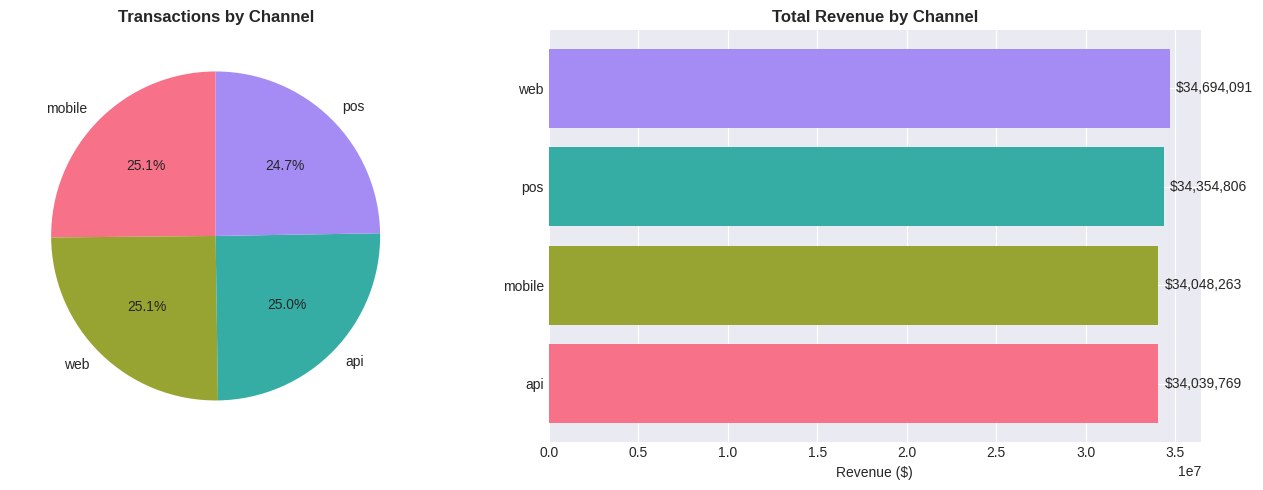

In [11]:
# Visualize channel distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Transaction count by channel
ax1 = axes[0]
channel_counts = df['channel'].value_counts()
colors = sns.color_palette('husl', len(channel_counts))
ax1.pie(channel_counts, labels=channel_counts.index, autopct='%1.1f%%', colors=colors, startangle=90)
ax1.set_title('Transactions by Channel', fontsize=12, fontweight='bold')

# Revenue by channel
ax2 = axes[1]
revenue_by_channel = df.groupby('channel')['revenue'].sum().sort_values(ascending=True)
ax2.barh(revenue_by_channel.index, revenue_by_channel.values, color=colors)
ax2.set_title('Total Revenue by Channel', fontsize=12, fontweight='bold')
ax2.set_xlabel('Revenue ($)')
for i, v in enumerate(revenue_by_channel.values):
    ax2.text(v + revenue_by_channel.max()*0.01, i, f'${v:,.0f}', va='center')

plt.tight_layout()
plt.savefig('eda_channel_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

## 8. Daily Trends

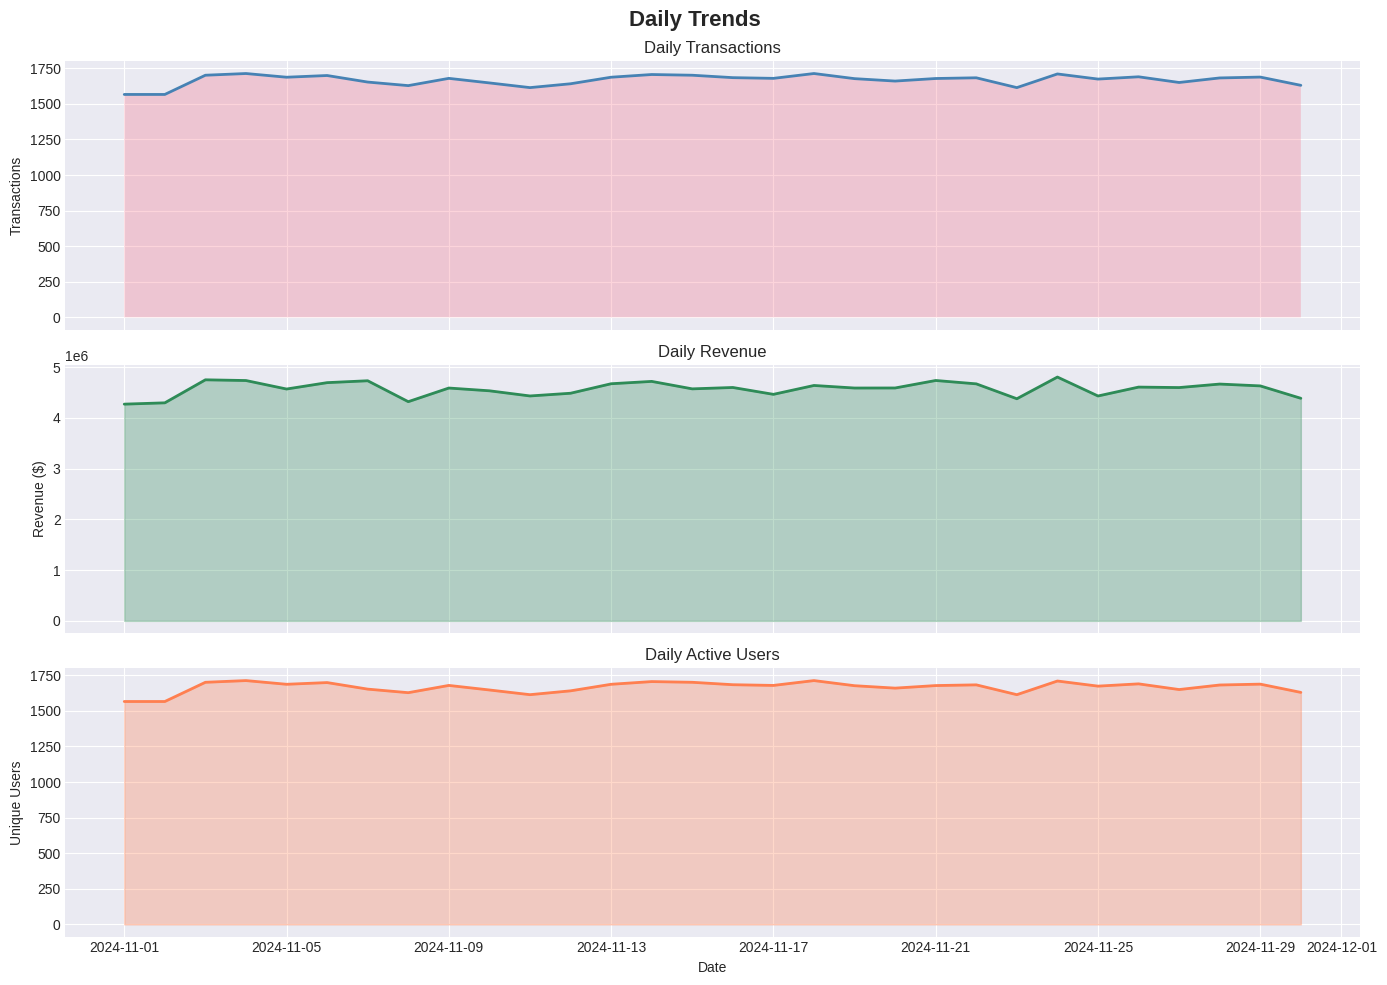

In [12]:
# Daily aggregations
daily_stats = df.groupby('date').agg({
    'id': 'count',
    'revenue': 'sum',
    'user_id': 'nunique'
}).reset_index()
daily_stats.columns = ['date', 'transactions', 'revenue', 'unique_users']

fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
fig.suptitle('Daily Trends', fontsize=16, fontweight='bold')

# Transactions
axes[0].plot(daily_stats['date'], daily_stats['transactions'], color='steelblue', linewidth=2)
axes[0].fill_between(daily_stats['date'], daily_stats['transactions'], alpha=0.3)
axes[0].set_ylabel('Transactions')
axes[0].set_title('Daily Transactions')

# Revenue
axes[1].plot(daily_stats['date'], daily_stats['revenue'], color='seagreen', linewidth=2)
axes[1].fill_between(daily_stats['date'], daily_stats['revenue'], alpha=0.3, color='seagreen')
axes[1].set_ylabel('Revenue ($)')
axes[1].set_title('Daily Revenue')

# Unique users
axes[2].plot(daily_stats['date'], daily_stats['unique_users'], color='coral', linewidth=2)
axes[2].fill_between(daily_stats['date'], daily_stats['unique_users'], alpha=0.3, color='coral')
axes[2].set_ylabel('Unique Users')
axes[2].set_title('Daily Active Users')
axes[2].set_xlabel('Date')

plt.tight_layout()
plt.savefig('eda_daily_trends.png', dpi=150, bbox_inches='tight')
plt.show()

**Interpretation:**
- Look for weekly seasonality (weekday vs weekend patterns)
- Identify any anomalous spikes or dips that may need investigation
- User count trends indicate engagement/acquisition patterns

## 9. Summary & Next Steps

### Key Findings
1. **Data Quality**: Identified any missing values and data completeness
2. **Distribution Characteristics**: Understood price, quantity, and revenue distributions
3. **Feature Relationships**: Analyzed correlations between numeric features
4. **Business Metrics**: Established baseline KPIs for monitoring

### Recommended Next Steps
- Proceed to baseline modeling (`02_baselines.ipynb`)
- Engineer additional features based on user behavior patterns
- Set up automated data quality checks

In [13]:
print(f"\nEDA Complete! Notebook executed at: {datetime.now().isoformat()}")


EDA Complete! Notebook executed at: 2025-12-15T16:53:27.269413
